In [673]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import math
from matplotlib import animation

# 迷路の情報

In [674]:
source_start_goal = [(0,99)]
gridworld_0 = [[1, 1, 1, 1, 0],
			   [0, 1, 1, 1, 1],
			   [1, 0, 0, 1, 1],
			   [1, 1, 0, 1, 1],
			   [1, 1, 1, 1, 1]]

gridworld_1 =  [[1, 1, 1, 1, 0, 1, 0, 1, 1, 0],
                [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                [1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
                [1, 1, 0, 0, 2, 2, 0, 0, 0, 1],
                [0, 1, 1, 1, 1, 0, 0, 1, 1, 1],
                [1, 1, 0, 1, 1, 0, 1, 1, 2, 1],
                [0, 1, 1, 1, 0, 1, 2, 1, 0, 1],
                [0, 1, 1, 1, 1, 0, 0, 1, 0, 1],
                [0, 1, 0, 0, 1, 1, 0, 1, 0, 0],
                [0, 1, 1, 1, 0, 1, 2, 1, 1, 1]]

gridworld_2 =  [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
                [1, 1, 0, 1, 0, 0, 0, 0, 0, 2],
                [0, 1, 1, 1, 0, 0, 0, 1, 0, 2],
                [1, 1, 0, 1, 0, 0, 1, 1, 0, 2],
                [1, 0, 0, 1, 0, 0, 0, 1, 0, 2],
                [1, 1, 1, 1, 0, 1, 1, 1, 0, 2],
                [1, 1, 1, 1, 0, 0, 0, 0, 0, 2],
                [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

gridworld_3 =  [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
                [1, 1, 0, 1, 0, 0, 0, 0, 0, 1],
                [0, 1, 1, 1, 0, 0, 0, 1, 0, 2],
                [1, 1, 0, 1, 0, 0, 1, 1, 0, 2],
                [1, 0, 0, 1, 0, 0, 0, 1, 0, 2],
                [1, 1, 1, 1, 0, 1, 1, 1, 0, 2],
                [1, 1, 1, 1, 0, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

action_dict = {"UP":0, "RT":1, "DN":2, "LT":3}

reward_all_list = []
t_all_list = []

# 迷路の情報から到達可能場所を求める関数

In [675]:
def maze_info_accesable_state(gridworld):
	acc_info = [] #各状態でとれる行動は1、とれない行動は0を保持するリスト。初期方策を求めるために使用

	for i in range(gridsize):
		for j in range(gridsize):
			acc_info_state = [1]*len(action_dict) #最初はどの状態もすべての行動をとれると仮定

			if i - 1 < 0 or gridworld[i-1][j] == 0:
				acc_info_state[0] = 0
			if j + 1 >= gridsize or gridworld[i][j+1] == 0:
				acc_info_state[1] = 0
			if i + 1 >= gridsize or gridworld[i+1][j] == 0:
				acc_info_state[2] = 0
			if j - 1 < 0 or gridworld[i][j-1] == 0:
				acc_info_state[3] = 0

			acc_info.append(acc_info_state)

	acc_info = np.array(acc_info)
	return acc_info

# e-greedy

In [676]:
def e_greedy(state, epsilon, Q):
  if random.random() < epsilon:
    action = random.randrange(len(action_dict))
  else:
    action = np.argmax(Q[state, :])
  
  return action

def hp_e_greedy(state, epsilon, hp, Q):
	if random.random() < epsilon:
		action = random.randrange(len(action_dict))
	else:
		action = np.argmax(Q[hp, state, :])

	return action

# 壁かどうか判断する関数

In [677]:
def is_wall(state, action):
	if acc_info[state][action] == 0: #進めなかったら
		return True
	else:
		return False

# 罠かどうか判断する関数

In [678]:
def is_trap(state, trappoint):
	for trap in trappoint:
		if state==trap:
			return True
	return False

# 行動を決定

In [679]:
def step_agent(state, action, startpoint, trappoint, goalpoint, hp):
	is_goal = False

	if is_trap(state, trappoint): #罠にかかるようだったら
		hp_next = hp -1
	else:
		hp_next = hp

	#ゴールしたら
	if state == goalpoint:
		state_next = None
		hp_next = None
		is_goal = True
	
	#ゲームオーバーなら
	elif hp == 0:
		state_next = None
		hp_next = None

	elif is_wall(state, action): #壁にぶつかるようだったら
		return state, hp, is_goal

	else:
		if action == action_dict['UP']:
			state_next = state - gridsize
		elif action == action_dict['RT']:
			state_next = state + 1
		elif action == action_dict['DN']:
			state_next = state + gridsize
		elif action == action_dict['LT']:
			state_next = state - 1

	return state_next, hp_next, is_goal

# 報酬関数

In [680]:
def get_reward(state, action, state_next, startpoint, goalpoint, trappoint, hp, hp_next, t):
	if state == goalpoint: #ゴールした場合
		return 1
	elif state == state_next: #移動に失敗(壁など)
		return  -0.01
	elif is_trap(state, trappoint): #罠にかかった場合
		return -0.25
	elif hp_next == 0: #ゲームオーバー
		return -1
	else:
		return 0.01

# Q学習

In [681]:
def Qlearning(Q, epsilon, alpha, gamma, num_source, startpoint, trappoint, goalpoint):
	is_goal = False
	state = startpoint
	reward_sum = 0
	reward_list = []
	t = 0
	hp = 5
	state_action_hist = []

	while not is_goal:
		action = e_greedy(state, epsilon, Q)
		state_next, hp_next, is_goal = step_agent(state, action, startpoint, trappoint, goalpoint, hp)
		reward = get_reward(state, action, state_next, startpoint, goalpoint, trappoint, hp, hp_next, t)
		reward_sum += reward
		Q[state, action] += alpha * (reward + gamma * np.max(Q[state_next, :]) - Q[state, action])

		state_action_hist.append((state, action))

		if hp_next == 0:
			break
		# if t > 10000:
		# 	break

		state = state_next
		hp = hp_next
		t += 1
	
	return reward_sum, t, Q, state_action_hist

# HPを考慮したQ学習

In [682]:
def hp_Qlearning(Q, epsilon, alpha, gamma, num_source, startpoint, trappoint, goalpoint):
	is_goal = False
	state = startpoint
	reward_sum = 0
	t = 0
	hp = 5
	state_action_hist = []

	while not is_goal:
		action = hp_e_greedy(state, epsilon, hp, Q)
		state_next, hp_next, is_goal = step_agent(state, action, startpoint, trappoint, goalpoint, hp)
		reward = get_reward(state, action, state_next, startpoint, goalpoint, trappoint, hp, hp_next, t)
		reward_sum += reward
		Q[hp, state, action] += alpha * (reward + gamma * np.max(Q[hp_next, state_next, :]) - Q[hp, state, action])

		state_action_hist.append((state, action))

		if hp_next == 0:
			break
		if t > 50000:
			break

		state = state_next
		hp = hp_next
		t += 1

	return reward_sum, t, Q, state_action_hist

# Sarsa

In [683]:
def Sarsa(Q, epsilon, alpha, gamma, num_source, startpoint, trappoint, goalpoint):
	is_goal = False
	state = startpoint
	reward_sum = 0
	t = 0
	hp = 5
	state_action_hist = []
	
	action = e_greedy(state, epsilon, Q)
	while not is_goal:
		state_next, hp_next, is_goal = step_agent(state, action, startpoint, trappoint, goalpoint, hp)
		reward = get_reward(state, action, state_next, startpoint, goalpoint, trappoint, hp, hp_next, t)
		action_next = e_greedy(state_next, epsilon, Q)
		reward_sum += reward
		state_action_hist.append((state, action))

		if state_next is None:
			Q[state, action] = Q[state, action] + gamma * (reward - Q[state, action])
		else:
			Q[state, action] += alpha * (reward + gamma * Q[state_next, action_next] - Q[state, action])

		if hp_next == 0:
			break
		# if t > 10000:
		# 	break

		state = state_next
		action = action_next
		hp = hp_next
		t += 1
	
	return reward_sum, t, Q, state_action_hist

# HPを考慮したSarsa 

In [684]:
def hp_Sarsa(Q, epsilon, alpha, gamma, num_source, startpoint, trappoint, goalpoint):
	is_goal = False
	state = startpoint
	reward_sum = 0
	t = 0
	hp = 5
	state_action_hist = []
	
	action = hp_e_greedy(state, epsilon, hp, Q)
	while not is_goal:
		state_next, hp_next, is_goal = step_agent(state, action, startpoint, trappoint, goalpoint, hp)
		reward = get_reward(state, action, state_next, startpoint, goalpoint, trappoint, hp, hp_next, t)
		action_next = hp_e_greedy(state_next, epsilon, hp_next, Q)
		reward_sum += reward
		state_action_hist.append((state, action))

		if state_next is None:
			Q[hp, state, action] = Q[hp, state, action] + gamma * (reward - Q[hp, state, action])
		else:
			Q[hp, state, action] += alpha * (reward + gamma * Q[hp_next, state_next, action_next] - Q[hp, state, action])

		if hp_next == 0:
			break
		if t > 50000:
			break

		state = state_next
		action = action_next
		hp = hp_next
		t += 1
	
	return reward_sum, t, Q, state_action_hist

#  各種設定 
使用する迷路、アルゴリズム、シミュレーション数、エピソード数

In [685]:
gridsize = 10
source_list = [gridworld_2]

alg_list = ["hp_Qlearning", "Qlearning", "hp_Sarsa", "Sarsa"]
simulate = 10 #シミュレーション回数
episode = 5000#エピソード数

# タスクを実行

In [686]:
for i, gridworld in enumerate(source_list):
	startpoint, goalpoint = source_start_goal[i]
	acc_info = maze_info_accesable_state(gridworld)
	trappoint = []
	for i in range(gridsize):
		for j in range(gridsize):
			if gridworld[i][j] == 2:
				trappoint.append(i + j + i*(gridsize-1))
	
	#アルゴリズム
	for alg in alg_list:
		result_list_total = np.zeros((episode, 2)) #reward, step回数がエピソード分ある

		#シミュレーション
		for sim in tqdm(range(simulate)):
			Q = np.zeros((gridsize*gridsize, len(action_dict)))
			hp_Q = np.zeros((6, gridsize*gridsize, len(action_dict)))
			epsilon = 1.0
			alpha = 0.8
			gamma = 0.99
			reward_sim_total = 0 #1シミュレーションの報酬の合計
			result_list = [[] for i in range(episode)]
			Q_and_stateaction = []

			#エピソード
			for epi in range(episode):
				if alg == "Sarsa":
					reward, t, Q, state_action_hist = Sarsa(Q, epsilon, alpha, gamma, i, startpoint, trappoint, goalpoint)
					Sarsa_state_hist = state_action_hist
					Sarsa_t = t
					Sarsa_Q = Q
				elif alg == "Qlearning":
					reward, t, Q, state_action_hist = Qlearning(Q, epsilon, alpha, gamma, i, startpoint, trappoint, goalpoint)
					Q_state_hist = state_action_hist
					Q_t = t
					Q_Q = Q
				elif alg == "hp_Qlearning":
					reward, t, hp_Q, state_action_hist = hp_Qlearning(hp_Q, epsilon, alpha, gamma, i, startpoint, trappoint, goalpoint)
					hp_Q_state_hist = state_action_hist
					hp_Q_t = t
					hp_Q_Q = hp_Q
				elif alg == "hp_Sarsa":
					reward, t, hp_Q, state_action_hist = hp_Sarsa(hp_Q, epsilon, alpha, gamma, i, startpoint, trappoint, goalpoint)
					hp_Sarsa_state_hist = state_action_hist
					hp_Sarsa_t = t
					hp_Sarsa_Q = hp_Q
				else:
					print("Not exist algorithm!")
					exit()

				reward_sim_total += reward
				result_list[epi] = [reward, t]

				alpha = alpha - 0.00014
				if epi < 4000:
					epsilon = epsilon - 0.00025

			result_list_total = result_list_total + result_list

			Q_and_stateaction.append(Q)
			Q_and_stateaction.append(hp_Q)
			Q_and_stateaction.append(state_action_hist)
			Q_and_stateaction = np.array(Q_and_stateaction)
			#np.save('source_Q_task'+str(i)+'_start'+str(startpoint)+'_goal'+str(goalpoint), Q)
			
		result_list_total = result_list_total / simulate #平均
		reward_all_list.append(result_list_total[:, 0]) #報酬の取り出し
		t_all_list.append(result_list_total[:, 1]) #総ステップ回数の取り出し

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-686-ee8795d02fc3>:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Q_and_stateaction = np.array(Q_and_stateaction)
100%|██████████| 10/10 [01:31<00:00,  9.17s/it]


# 軌跡を表示

In [687]:
for ii in alg_list:
  print("*****", ii, "*****")
  if ii == "Qlearning":
    print(Q_state_hist)
    print(Q_t, "steps")
  elif ii == "Sarsa":
    print(Sarsa_state_hist)
    print(Sarsa_t, "steps")
  elif ii == "hp_Qlearning":
    print(hp_Q_state_hist)
    print(hp_Q_t, "steps")
  elif ii == "hp_Sarsa":
    print(hp_Sarsa_state_hist)
    print(hp_Sarsa_t, "steps")

***** hp_Qlearning *****
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (19, 2), (29, 2), (39, 0), (29, 3), (28, 3), (27, 3), (26, 3), (25, 3), (24, 3), (23, 2), (33, 2), (43, 2), (53, 2), (63, 2), (73, 2), (83, 2), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1)]
33 steps
***** Qlearning *****
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (19, 2), (29, 3), (28, 3), (27, 3), (26, 3), (25, 3), (24, 3), (23, 2), (33, 2), (43, 2), (53, 2), (63, 2), (73, 2), (83, 2), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 3)]
31 steps
***** hp_Sarsa *****
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (19, 2), (29, 3), (28, 3), (27, 3), (26, 3), (25, 3), (24, 3), (23, 2), (33, 2), (43, 2), (53, 2), (63, 2), (73, 2), (83, 2), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 0)]
31 steps
***** Sarsa *****
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7

# グラフを表示

In [688]:
Q_reward = [reward_all_list[0], reward_all_list[1]]
Q_step = [t_all_list[0], t_all_list[1]]
Sarsa_reward = [reward_all_list[2], reward_all_list[3]]
Sarsa_step = [t_all_list[2], t_all_list[3]]
Q_alg = ["hp_Qlearning", "Qlearning"]
Sarsa_alg = ["hp_Sarsa", "Sarsa"]

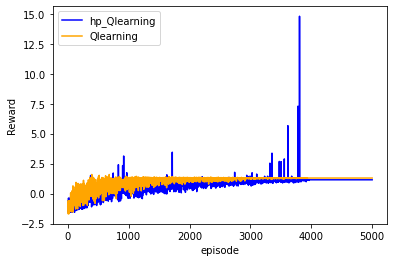

In [696]:
x = range(episode)
y_list = Q_reward
alg = Q_alg
colorlist = ["blue", "orange"]
plt.xlabel("episode")
plt.ylabel("Reward")

i = 0
for y in y_list:
  plt.plot(x, y, color=colorlist[i], label=alg[i])
  i += 1

plt.legend(loc=0)
plt.show()

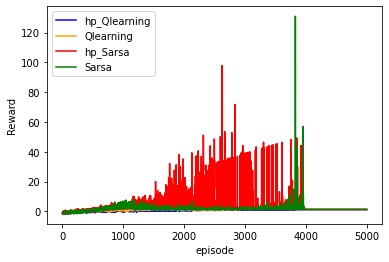

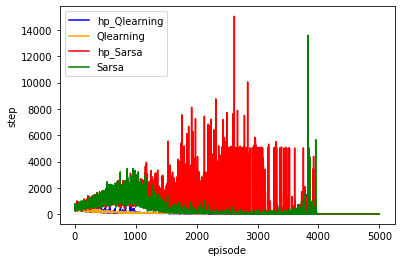

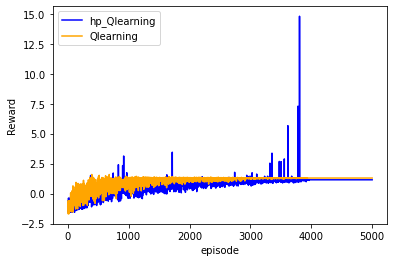

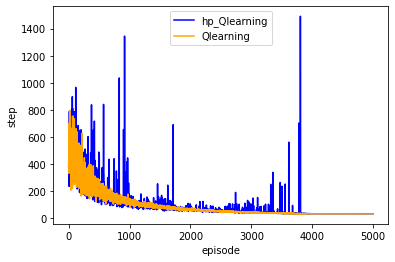

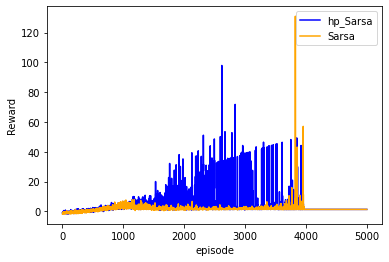

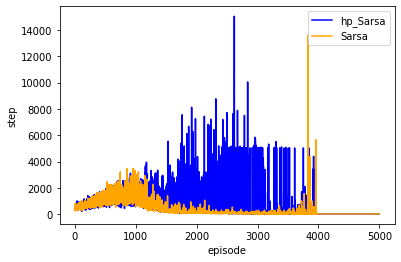

In [690]:
#グラフ表示関数
def plotgraphs(x_name, y_name, x, y_list, alg_list):
  colorlist = ["blue", "orange", "red", "green", "magenta"]
  plt.xlabel(x_name)
  plt.ylabel(y_name)

  i = 0
  for y in y_list:
    plt.plot(x, y, color=colorlist[i], label=alg_list[i])
    i += 1
  
  plt.legend(loc=0)
  plt.show()

#グラフ表示
plotgraphs("episode", "Reward", range(episode), reward_all_list, alg_list)
plotgraphs("episode", "step", range(episode), t_all_list, alg_list)
plotgraphs("episode", "Reward", range(episode), Q_reward, Q_alg)
plotgraphs("episode", "step", range(episode), Q_step, Q_alg)
plotgraphs("episode", "Reward", range(episode), Sarsa_reward, Sarsa_alg)
plotgraphs("episode", "step", range(episode), Sarsa_step, Sarsa_alg)

# 迷路の描画

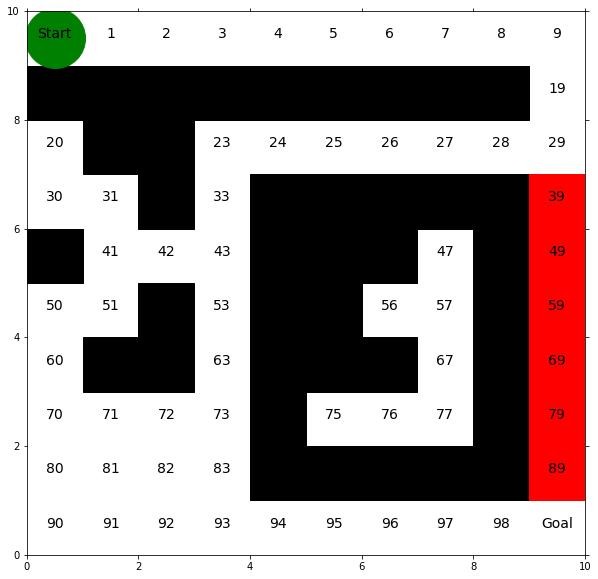

In [691]:
#背景描画
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()

for i in range(gridsize):
  for j in range(gridsize):
    if i+j+i*(gridsize-1) == 0:
      plt.text(0.5+j, 9.5-i, "Start", size=14, ha='center')
    elif i+j+i*(gridsize-1) == 99:
      plt.text(0.5+j, 9.5-i, "Goal", size=14, ha='center')
    elif gridworld[i][j] == 0:
      ax.axvspan(0+j, 1+j, 0.9-i/10, 1-i/10, color = "black")
    elif gridworld[i][j] == 2:
      ax.axvspan(0+j, 1+j, 0.9-i/10, 1-i/10, color = "red")
      plt.text(0.5+j, 9.5-i, i + j + i*(gridsize-1), size=14, ha='center')
    else:
      plt.text(0.5+j, 9.5-i, i + j + i*(gridsize-1), size=14, ha='center')

ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')

line, = ax.plot([0.5], [9.5], marker="o", color='g', markersize=60)

state_history = Q_state_hist

In [692]:
#背景画像の初期化
def init():
  line.set_data([], [])
  return (line,)

#フレームごとの描画内容
def animate(i):
  state = state_history[i][0]
  x = (state % 10) + 0.5
  y = 9.5 - int(state / 10)
  line.set_data(x, y)
  return (line,)

In [693]:

state_history = Q_state_hist
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(state_history), interval=200, repeat=False)
anim.save("Q.gif", writer="pillow")

state_history = Sarsa_state_hist
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(state_history), interval=200, repeat=False)
anim.save("Sarsa.gif", writer="pillow")

state_history = hp_Q_state_hist
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(state_history), interval=200, repeat=False)
anim.save("hp_Q.gif", writer="pillow")

state_history = hp_Sarsa_state_hist
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(state_history), interval=200, repeat=False)
anim.save("hp_Sarsa.gif", writer="pillow")